<a href="https://colab.research.google.com/github/SamwelJane/Whatsapp-texts-analysis/blob/master/WHATSAPP_CEO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Whatsapp Group (CEOs) Chat Data Analysis using python.

###Iibraries


In [1]:
!pip install emoji

     |████████████████████████████████| 51kB 1.6MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=130325b64a0e86f10e3ab7b2d05c005560e27e97d0316237c1e9ca70a7bb717e
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [1]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
% matplotlib inline

In [3]:
! git clone https://github.com/amueller/word_cloud.git
% cd word_cloud
! pip install .

Cloning into 'word_cloud'...
remote: Enumerating objects: 186, done.
remote: Counting objects: 100% (186/186), done.
remote: Compressing objects: 100% (134/134), done.
remote: Total 5853 (delta 85), reused 118 (delta 52), pack-reused 5667
Receiving objects: 100% (5853/5853), 107.06 MiB | 14.21 MiB/s, done.
Resolving deltas: 100% (3420/3420), done.
/content/word_cloud
Processing /content/word_cloud
  Created wheel for wordcloud: filename=wordcloud-1.6.0.post90+gbda4195-cp36-cp36m-linux_x86_64.whl size=338631 sha256=ed0d7aeb49521f3ea9b50f91af54a35304d037d31d8eb8b76113f1656ef63e1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-lfdm7dg3/wheels/c9/9e/fe/b14c026a2af072dcf59543bce68dcdfff8a5362e6bb11242d9
Successfully built wordcloud
  Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:


In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

CEO's group

In [2]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9][0-9]) (AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [3]:
def FindAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (Kenya)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (Kenya)
        '([\w]+)[\u263a-\U0001f999]+:',    # Name and Emoji              
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [6]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message


In [5]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/drive/My Drive/WhatsApp Chat with EA CEOs Forum 2020.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message, = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)

In [7]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author','Message']) # Initialising a pandas Dataframe.
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df['Contact']=df.Message.str.slice(0,15)

In [9]:
df['Messages']= df.Message.str.slice(16,200)

In [16]:
# obtaining phone number
def find_phone_number(Contact):
  line=re.findall(r"\b\d{10}\b",Contact)
  return "".join(line)

# find_phone_number



In [18]:
df['phone_number']=df['Contact'].apply(lambda x: find_phone_number(x))

In [32]:
df.head(2)

,Date,Time,Author,Message,Contact,Messages,phone_number,emoji,Message_without
0,2019-11-28,3:27 AM,None,"Kimani Patrick created group ""#YCB2020 Insights""",Kimani Patrick,"reated group ""#YCB2020 Insights""",,[],"Kimani Patrick created group ""#YCB2020 Insights"""
1,2019-11-28,3:30 AM,None,"Kimani 👑: Team, I have created an exclusive wh...","Kimani 👑: Team,",I have created an exclusive whatsAppp group fo...,,"[crown, Team, I have created an exclusive wha...","Kimani : Team, I have created an exclusive wha..."


In [20]:
# Convert imoji to text
def find_emoji(Message):
    emo_text=emoji.demojize(Message)
    line=re.findall(r'\:(.*?)\:',emo_text)
    return line



In [22]:
Message="Kimani 👑: Team, we have created an"
find_emoji(Message)

['crown']

In [23]:
df['emoji']=df['Message'].apply(lambda x: find_emoji(x))

In [45]:
df.head()

,Date,Time,Author,Message,Contact,Messages,phone_number,emoji,Message_without,members_tagged,search_day
0,2019-11-28,3:27 AM,None,"Kimani Patrick created group ""#YCB2020 Insights""",Kimani Patrick,"reated group ""#YCB2020 Insights""",,[],"Kimani Patrick created group ""#YCB2020 Insights""",<function find_at at 0x7fbf4b89de18>,False
1,2019-11-28,3:30 AM,None,"Kimani 👑: Team, I have created an exclusive wh...","Kimani 👑: Team,",I have created an exclusive whatsAppp group fo...,,"[crown, Team, I have created an exclusive wha...","Kimani : Team, I have created an exclusive wha...",<function find_at at 0x7fbf4b89de18>,False
2,2019-11-28,3:35 AM,None,Kimani Patrick changed the group description,Kimani Patrick,hanged the group description,,[],Kimani Patrick changed the group description,<function find_at at 0x7fbf4b89de18>,False
3,2019-11-28,3:35 AM,None,"Kimani 👑: Team, we have created an exclusive w...","Kimani 👑: Team,",we have created an exclusive whatsAppp group f...,,"[crown, Team, we have created an exclusive wh...","Kimani : Team, we have created an exclusive wh...",<function find_at at 0x7fbf4b89de18>,False
4,2019-11-28,3:37 AM,None,+254 775 909655 joined using this group's invi...,+254 775 909655,joined using this group's invite link,,[],+254 775 909655 joined using this group's invi...,<function find_at at 0x7fbf4b89de18>,False


* Message without imoji

In [25]:
def remove_emoji(Message):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', Message)

In [30]:
sentence="Its all about \U000024C2 "
print(sentence)
remove_emoji(sentence)

Its all about Ⓜ 


'Its all about  '

In [27]:
# Column Message without emoji 
df['Message_without']=df['Message'].apply(lambda x: remove_emoji(x))

In [29]:
df.head(2)

,Date,Time,Author,Message,Contact,Messages,phone_number,emoji,Message_without
0,2019-11-28,3:27 AM,None,"Kimani Patrick created group ""#YCB2020 Insights""",Kimani Patrick,"reated group ""#YCB2020 Insights""",,[],"Kimani Patrick created group ""#YCB2020 Insights"""
1,2019-11-28,3:30 AM,None,"Kimani 👑: Team, I have created an exclusive wh...","Kimani 👑: Team,",I have created an exclusive whatsAppp group fo...,,"[crown, Team, I have created an exclusive wha...","Kimani : Team, I have created an exclusive wha..."


* Members in the group who have been tagged in the conversation

In [33]:
def find_at(Message):
    line=re.findall(r'(?<=@)\w+',Message)
    return " ".join(line)

In [35]:
sentence="@Kimani,can you help me out with Content creation"
find_at(sentence)

'Kimani'

In [37]:
df['members_tagged']= df['Message'].apply(lambda x: find_at)

* Is the key word present in the sentence

In [38]:
def search_string(Message,key):
    return bool(re.search(r''+key+'', Message))

In [39]:
sentence="Inverks gives us more information"
search_string(sentence,'day')

False

In [40]:
df['search_day']=df['Message'].apply(lambda x : search_string(x,'day'))

In [42]:
df.search_day.unique()

array([False,  True])

In [46]:
def valid_phone_code(string):
    text=re.findall(r'^([0-9]){3}(-)([0-9]){3}(-)(\d+)$',string)
    if text!=[]:
        print("{} is valid Kenya Phone number wth country code".format(string))
    else:
        print("{} is not a valid Kenya Phone number wth country code".format(string))

In [ ]:
df.to_csv('CEO.csv')

In [ ]:
# col=['Message']
# df=df.drop(['Message'],axis=1)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5373 entries, 0 to 5372
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5373 non-null   datetime64[ns]
 1   Time      5373 non-null   object        
 2   Author    2008 non-null   object        
 3   Message   5373 non-null   object        
 4   Contact   5373 non-null   object        
 5   Messages  5373 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 252.0+ KB


##Print Group members

In [ ]:
df.Author.unique()


array([None, 'Kosgey Clive', 'Kimani Patrick', 'Daisy',
       'Joseph Obel Ochieng', 'Caroline Kusimba', 'Cecilia',
       'Michael YCB', 'James Midunga', 'John Mwanu', 'Millicent Wangui',
       'Zawadi Eunice', 'Muriithi Ngari', 'Tushar Vyas', 'Ms Maria',
       'Sylvia Kendi', 'Josephine Irungu', 'Ads Patricia',
       'Junky Bins Lucy', 'Joseph Njuguna Maina', 'Mageto', 'Ian Dennis',
       'Stephen Njoroge', 'Paul Mugo', 'Radido', 'Tony Mwongela',
       'Njoki Waigwa', 'Violin Nzioka', 'Sheilla Koileken', 'Ashley',
       'Angela', 'Sammy Kibe', 'Magazine Emmanuella Aboa',
       'Karanja Kiarie', 'Nancy Amunga', 'David Macharia', 'Emma Kavuku',
       'Odipo Otieno', 'Shirlene Nafula', 'Cliff CEO',
       'UrbanTex Kabegi Muturi', 'Counselor Cynthia Mutheu',
       'Shieh Gicheru', 'Magazine Blevince Okeyo', 'Phanuel Chebii',
       'Peter Gakingo YCB2020', 'Bayes Wakubwa Miquel',
       'Boniface Kimoni CFO', 'Cyrus Senior', 'Inversk Intern Philip'],
      dtype=object)

In [ ]:
total_messages = df.shape[0]
print(total_messages)

5373


In [ ]:
media_messages = df[df['Message'] == '<Media omitted>'].shape[0]
print(media_messages)

310


In [ ]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

df["emoji"] = df["Message"].apply(split_count)

In [ ]:
emojis = sum(df['emoji'].str.len())
print(emojis)

3175


In [ ]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()


In [ ]:
links = np.sum(df.urlcount)

In [ ]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 5373
Media: 310
Emojis: 3175
Links: 939


In [ ]:
media_messages_df = df[df['Message'] == '<Media omitted>']

In [ ]:
messages_df = df.drop(media_messages_df.index)

In [ ]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5063 entries, 0 to 5372
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5063 non-null   datetime64[ns]
 1   Time      5063 non-null   object        
 2   Author    1698 non-null   object        
 3   Message   5063 non-null   object        
 4   Contact   5063 non-null   object        
 5   Messages  5063 non-null   object        
 6   emoji     5063 non-null   object        
 7   urlcount  5063 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 356.0+ KB


In [ ]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [ ]:
messages_df.head()

,Date,Time,Author,Message,Contact,Messages,emoji,urlcount,Letter_Count,Word_Count,MessageCount
0,2020-01-16,9:32 AM,None,+254 722 117028 changed to +254 724 973754,+254 722 117028,changed to +254 724 973754,[],0,42,4,1
1,2020-01-16,9:34 AM,None,+254 724 973754 changed to +254 722 117028,+254 724 973754,changed to +254 722 117028,[],0,42,4,1
2,2020-01-16,1:45 PM,None,You added Kosgey Clive,You added Kosge,Clive,[],0,22,4,1
3,2020-01-16,2:29 PM,Kosgey Clive,Thanks for the add,Thanks for the,dd,[],0,18,4,1
4,2020-01-16,2:36 PM,None,+254 722 306734 left,+254 722 306734,left,[],0,20,4,1


In [ ]:
messages_df["emojicount"]= df['emoji'].str.len()

In [ ]:
# Creates a list of unique Authors - ['Kimani Patrick', 'Cynthia Mutheu', .........]
l = messages_df.Author.unique()

for i in range(len(l)):
  # Filtering out messages of particular user
  req_df= messages_df[messages_df["Author"] == l[i]]
  # req_df will contain messages of only one particular user
  print(f'Stats of {l[i]} -')
  # shape will print number of rows which indirectly means the number of messages
  print('Messages Sent', req_df.shape[0])
  #Word_Count contains of total words in one message. Sum of all words/ Total Messages will yield words per message
  words_per_message = (np.sum(req_df['Word_Count']))/req_df.shape[0]
  print('Words per message', words_per_message)
  #media conists of media messages
  media = media_messages_df[media_messages_df['Author'] == l[i]].shape[0]
  print('Media Messages Sent', media)
  # emojis conists of total emojis
  emojis = sum(req_df['emoji'].str.len())
  print('Emojis Sent', emojis)
  #links consist of total links
  links = sum(req_df["urlcount"])   
  print('Links Sent', links)   
  print()

Stats of None -
Messages Sent 0
Words per message nan
Media Messages Sent 0
Emojis Sent 0
Links Sent 0

Stats of Kosgey Clive -
Messages Sent 7
Words per message 233.0
Media Messages Sent 1
Emojis Sent 0
Links Sent 0

Stats of Kimani Patrick -
Messages Sent 321
Words per message 42.71028037383178
Media Messages Sent 96
Emojis Sent 270
Links Sent 123

Stats of Daisy -
Messages Sent 136
Words per message 281.8529411764706
Media Messages Sent 5
Emojis Sent 1458
Links Sent 595

Stats of Joseph Obel Ochieng -
Messages Sent 2
Words per message 1.5
Media Messages Sent 0
Emojis Sent 0
Links Sent 0

Stats of Caroline Kusimba -
Messages Sent 45
Words per message 26.844444444444445
Media Messages Sent 3
Emojis Sent 5
Links Sent 1

Stats of Cecilia -
Messages Sent 54
Words per message 5.962962962962963
Media Messages Sent 1
Emojis Sent 31
Links Sent 3

Stats of Michael YCB -
Messages Sent 63
Words per message 24.682539682539684
Media Messages Sent 6
Emojis Sent 23
Links Sent 6

Stats of James Midu

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in long_scalars



In [ ]:
total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

223


In [ ]:
total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('👇🏻', 1487), ('😂', 169), ('😊', 80), ('👇🏾', 77), ('🤣', 66), ('👇', 62), ('🤔', 52), ('😅', 51), ('👍', 50), ('✅', 49), ('👇🏽', 37), ('👏', 34), ('👌', 30), ('👏🏽', 30), ('🙏', 24), ('👌🏾', 23), ('😁', 23), ('😍', 22), ('👍🏼', 21), ('👌🏽', 20), ('😭', 20), ('👏🏼', 19), ('👌🏼', 19), ('😆', 19), ('🙏🏾', 18), ('🔥', 17), ('👏🏾', 17), ('😃', 15), ('😄', 14), ('💯', 13), ('😔', 13), ('👆', 13), ('🚫', 12), ('🙂', 12), ('😀', 12), ('🇰🇪', 12), ('👍🏾', 10), ('\U0001f973', 10), ('🙏🏽', 9), ('✨', 9), ('😳', 9), ('😜', 9), ('💪', 9), ('💪🏽', 9), ('👊🏾', 8), ('👍🏽', 8), ('🐓', 8), ('❤', 8), ('😉', 8), ('🤦🏾\u200d♂️', 8), ('🤗', 8), ('❓', 8), ('♥️', 8), ('🤝🏽', 7), ('👍🏿', 7), ('🙄', 7), ('🏃\u200d♀️', 7), ('🤓', 7), ('👏🏿', 7), ('✋🏽', 6), ('\U0001f97a', 6), ('\U0001f929', 6), ('👌🏻', 6), ('☺️', 6), ('🙏🏿', 5), ('🤑', 5), ('👋', 5), ('🙏🏻', 5), ('👆🏾', 5), ('🔶', 5), ('✋🏼', 5), ('😇', 5), ('👇🏼', 4), ('💸', 4), ('👉', 4), ('⚰', 4), ('🙈', 4), ('\U0001f928', 4), ('🙆🏾\u200d♂️', 4), ('☝🏾', 4), ('💵', 4), ('💰', 4), ('💪🏼', 4), ('👊🏻', 4), ('👍🏻', 3), ('📞', 3), ('👆

In [ ]:
emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

,emoji,count
0,👇🏻,1487
1,😂,169
2,😊,80
3,👇🏾,77
4,🤣,66
...,...,...
218,🤷🏾‍♀️,1
219,©,1
220,🕵️‍♂️,1
221,✊,1


In [ ]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [ ]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for None


Emoji Distribution for Kosgey Clive


Emoji Distribution for Kimani Patrick


Emoji Distribution for Daisy


Emoji Distribution for Joseph Obel Ochieng


Emoji Distribution for Caroline Kusimba


Emoji Distribution for Cecilia


Emoji Distribution for Michael YCB


Emoji Distribution for James Midunga


Emoji Distribution for Millicent Wangui


Emoji Distribution for Zawadi Eunice


Emoji Distribution for Muriithi Ngari


Emoji Distribution for Tushar Vyas


Emoji Distribution for Ms Maria


Emoji Distribution for Sylvia Kendi


Emoji Distribution for Josephine Irungu


Emoji Distribution for Ads Patricia


Emoji Distribution for Ian Dennis


Emoji Distribution for Stephen Njoroge


Emoji Distribution for Radido


Emoji Distribution for Tony Mwongela


Emoji Distribution for Njoki Waigwa


Emoji Distribution for Violin Nzioka


Emoji Distribution for Joseph Njuguna Maina


Emoji Distribution for Paul Mugo


Emoji Distribution for Sheilla Koileken


Emoji Distribution for Ashley


Emoji Distribution for Angela


Emoji Distribution for Sammy Kibe


Emoji Distribution for John Mwanu


Emoji Distribution for Karanja Kiarie


Emoji Distribution for Nancy Amunga


Emoji Distribution for David Macharia


Emoji Distribution for Magazine Emmanuella Aboa


Emoji Distribution for Junky Bins Lucy


Emoji Distribution for Odipo Otieno


Emoji Distribution for Emma Kavuku


Emoji Distribution for Cliff CEO


Emoji Distribution for Counselor Cynthia Mutheu


Emoji Distribution for UrbanTex Kabegi Muturi


Emoji Distribution for Shieh Gicheru


Emoji Distribution for Magazine Blevince Okeyo


Emoji Distribution for Phanuel Chebii


Emoji Distribution for Peter Gakingo YCB2020


Emoji Distribution for Bayes Wakubwa Miquel


Emoji Distribution for Cyrus Senior


Emoji Distribution for Inversk Intern Philip


In [ ]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [ ]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()

In [ ]:
date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [ ]:
auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

In [ ]:
auth[:15]

Text(0, 0.5, 'Time')

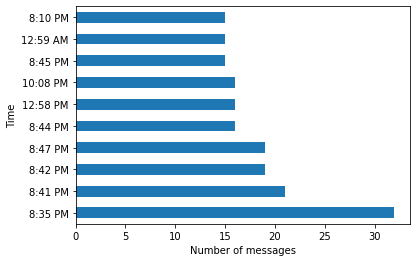

In [ ]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

2020-06-10    200
2020-07-02    185
2020-02-17    180
2020-04-28    149
2020-07-05    126
             ... 
2020-05-31      1
2020-02-01      1
2020-01-22      1
2020-01-18      1
2020-02-08      1
Name: Date, Length: 170, dtype: int64


Text(0, 0.5, 'Date')

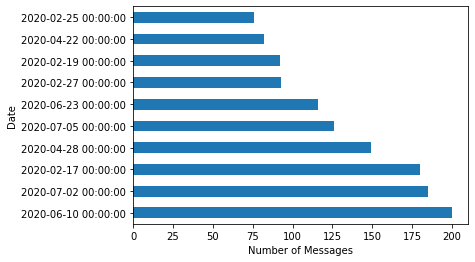

In [ ]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

In [ ]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 936817 words in all the messages.


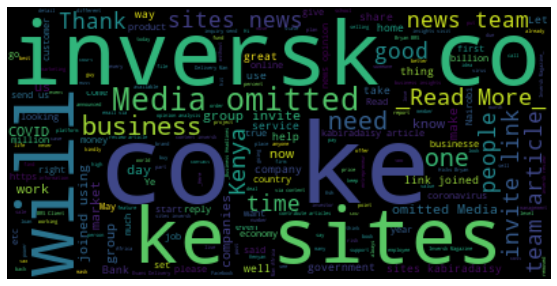

In [ ]:
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
  # Generate a word cloud image
  wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  text = " ".join(review for review in dummy_df.Message)
  stopwords = set(STOPWORDS)
  stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
  # Generate a word cloud image
  print('Author name',l[i])
  wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
  # Display the generated image:
  # the matplotlib way:
  
  plt.figure( figsize=(10,5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

Author name None


ValueError: ignored